In [1]:
import numpy as np
import jax
import jax.numpy as jnp
import scipy.stats as ss
import tensorly as tl
from tensorly.regression.tucker_regression import TuckerRegressor
from jax import grad
from references.SABR_Free import sabrMC
import time
import matplotlib.pyplot as plt


try:
    tl.set_backend('jax')
except:
    pass
tl.set_backend('jax')

/Users/carolinepei/Desktop/mfe/project/citi/term_2_citi_project/citi/lib/python3.8/site-packages/jax/_src/lib/__init__.py:33: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


In [2]:
def put_price(P0_K = 1., r=0.0, paths = 1000, steps=100, K=1.0, maturity = 1.0, data=None, seed=1):

    if data is not None:
        S = data.T
    else:
        np.random.seed(seed)
        start = time.time()
        S = sabrMC(F0 = P0_K * K, N=paths, T=steps, n_years=maturity).T
#         print(jnp.mean(S[:,-1]))
        end = time.time()
        print(f'path generation time: {end - start}')
    
    start = time.time()
    dt = maturity/(steps-1)         # time interval
    df = jnp.exp(-r * dt)           # discount factor per time interval
    
    H = jnp.maximum(K - S, 0)           # intrinsic values for put option
    V = jnp.zeros(H.shape)               # value matrix
    V = V.at[:,-1].set(H[:,-1]) 

    # Valuation by LS Method
    for t in range(steps-2, 0, -1):

        good_paths = np.array(H[:,t] > 0)        # paths where the intrinsic value is positive 
                                                 # the regression is performed only on these paths 

        # Valuation by Tucker Regression
        X = S[good_paths, t].reshape((-1,1,1)) # reshape to fill up dimensions
        y = V[good_paths, t+1] * df
        estimator = TuckerRegressor(weight_ranks=[1]*X.ndim, verbose=False, random_state=seed) # hyperparameter: reg_W (default: 1) 
        estimator.fit(X, y)
        fitted_values = estimator.predict(X) # predicted value of option (discounted, as `y` is discounted)

        exercise = jnp.zeros(len(good_paths)).astype(bool) # initialize
        # early exercise when value of early exericse at t > predicted value at t+1 (discounted to t)
        exerise = exercise.at[good_paths].set(H[good_paths,t] > fitted_values)

        V = V.at[exercise,t].set(H[exercise,t]) # set V equal to H where it is optimal to exercise 
        V = V.at[exercise,t+1:].set(0) # set future cash flows, for that path, equal to zero  
        discount_path = V[:,t] == 0 # paths where we didn't exercise
        V = V.at[discount_path,t].set(V[discount_path,t+1] * df) # set V[t] in continuation region

    V0 = jnp.mean(V[:,1]) * df  # discounted expectation of V[t=1]
    end = time.time()
    print(f'longstaff schwartz time: {end-start}')
    return V0

# print("normalize Example price= ", put_price(data=sample.T)) # should be US: 0.0797; EU: 0.0747; 0.07313426907833502
print("Example price= ", put_price(data=None)) # should be 0.0797; 0.07312965550779679

1.0
path generation time: 484.3299252986908
longstaff schwartz time: 17.523738145828247
Example price=  0.09283224714084289


In [3]:
print("Example price= ", put_price(data=None, paths=100)) # should be 0.0797; 0.07312965550779679

1.0
path generation time: 49.067626953125
longstaff schwartz time: 6.051353931427002
Example price=  0.09161354634099851


In [5]:
print('delta:')
delta = grad(put_price, argnums=0)
print(delta(1., 0.0, paths = 100, steps=100, K=1.0, maturity = 1.0, data=None))
# print('gamma:')
# gamma = grad(delta, argnums=0)
# print(gamma(1., 0.0, paths = 100, steps=100, K=1.0, maturity = 1.0, data=None))

delta:
Traced<ConcreteArray(1.0, dtype=float64, weak_type=True)>with<JVPTrace(level=2/0)> with
  primal = DeviceArray(1., dtype=float64, weak_type=True)
  tangent = Traced<ShapedArray(float64[], weak_type=True)>with<JaxprTrace(level=1/0)> with
    pval = (ShapedArray(float64[], weak_type=True), *)
    recipe = JaxprEqnRecipe(eqn_id=<object object at 0x16c1c2e60>, in_tracers=(Traced<ConcreteArray(1.0, dtype=float64, weak_type=True):JaxprTrace(level=1/0)>, Traced<ShapedArray(float64[], weak_type=True):JaxprTrace(level=1/0)>), out_tracer_refs=[<weakref at 0x2b4799a90; to 'JaxprTracer' at 0x1050419f0>], out_avals=[ShapedArray(float64[], weak_type=True)], primitive=xla_call, params={'device': None, 'backend': None, 'name': 'jvp(fn)', 'donated_invars': (False, False), 'inline': True, 'call_jaxpr': { lambda ; a:f64[] b:f64[]. let c:f64[] = mul b a in (c,) }}, effects=set(), source_info=SourceInfo(traceback=<jaxlib.xla_extension.Traceback object at 0x2b47b8a30>, name_stack=NameStack(stack=(Tra

Traced<ConcreteArray(0.1, dtype=float64)>with<JVPTrace(level=2/0)> with
  primal = DeviceArray(0.1, dtype=float64)
  tangent = Traced<ShapedArray(float64[])>with<JaxprTrace(level=1/0)> with
    pval = (ShapedArray(float64[]), *)
    recipe = JaxprEqnRecipe(eqn_id=<object object at 0x2b9673d90>, in_tracers=(Traced<ConcreteArray(1.0, dtype=float64):JaxprTrace(level=1/0)>, Traced<ShapedArray(float64[]):JaxprTrace(level=1/0)>), out_tracer_refs=[<weakref at 0x2bbfd61d0; to 'JaxprTracer' at 0x2bbfd6220>], out_avals=[ShapedArray(float64[])], primitive=xla_call, params={'device': None, 'backend': None, 'name': 'jvp(fn)', 'donated_invars': (False, False), 'inline': True, 'call_jaxpr': { lambda ; a:f64[] b:f64[]. let c:f64[] = mul b a in (c,) }}, effects=set(), source_info=SourceInfo(traceback=<jaxlib.xla_extension.Traceback object at 0x34ed34f30>, name_stack=NameStack(stack=(Transform(name='jvp'),))))
path generation time: 154.43394207954407
longstaff schwartz time: 62.961792945861816
Traced<Co

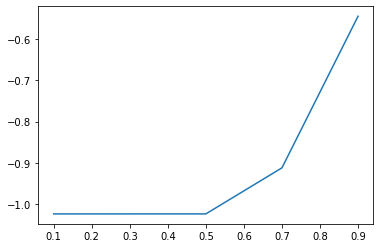

In [6]:
xi = jnp.linspace(0.1,0.9, num=5)
yi = [delta(x, 0.0, paths = 100, steps=100, K=1.0, maturity = 1.0, data=None) for x in xi]

plt.plot(xi,yi)

In [7]:
data = sabrMC(F0 = 1., N=100, T=100, n_years=1)
print(np.mean(data[:,-1]))

1.0
0.9182114680150586


In [8]:
print(type(data))

<class 'jaxlib.xla_extension.DeviceArray'>


In [9]:
print('delta:')
delta = grad(put_price, argnums=0)
print(delta(1., 0.0, paths = 100, steps=100, K=1.0, maturity = 1.0, data=data))
print('gamma:')
print(grad(delta)(1., 0.0, paths = 100, steps=100, K=1.0, maturity = 1.0, data=data))


delta:
longstaff schwartz time: 3.477100133895874
0.0
gamma:
longstaff schwartz time: 3.4879488945007324
0.0
